In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import qstock as qs

import talib

import cvxopt as opt
from cvxopt import blas,solvers
solvers.options['show_progress'] = False #求解器只输出结果不打印过程
from scipy.optimize import minimize
# 需要计算或填充的变量：
# 账面市值比（PB倒数）
# 流通市值
# 息税前利润
# 股东权益合计（不含少数股东）
# 总资产
# 收盘价
import cvxpy as cp
import mysql.connector
import scipy.optimize as sco

C:\Users\19550\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

import mysql.connector

In [3]:
mydb = mysql.connector.connect(
      host="172.31.50.91",
      user="guest",
      password="MH#123456",
       database="astocks"
    )
query1 = "SELECT td, chg,close, codenum,total_share,float_share,vol FROM market WHERE td >= 20100101"

df1 = pd.read_sql(query1, mydb)
df1 = df1.sort_values(by=['td'])


query2 = "SELECT fd,codenum, total_assets,total_liabilities,EBIT,total_shareholders_equity FROM finance"

df2 = pd.read_sql(query2, mydb)
df2 = df2.sort_values(by=['fd'])

C:\Users\19550\AppData\Local\Temp\ipykernel_11248\3149806562.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, mydb)
C:\Users\19550\AppData\Local\Temp\ipykernel_11248\3149806562.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, mydb)


In [ ]:
query3 = "SELECT td, chg,codenum FROM market WHERE td >= 20100101"

df3 = pd.read_sql(query3, mydb)
df3 = df3.sort_values(by=['td'])

In [4]:
df2 = df2[df2['fd' ]>= 20091231]

In [5]:
df1 = df1.reset_index(drop = True)
df2 = df2.reset_index(drop = True)
df2['td'] = df2['fd']

merged_df = pd.merge(df1, df2, on=['codenum', 'td'], how='outer')
merged_df = merged_df.sort_values(['codenum','td'], ascending=True)
merged_df['total_assets'].fillna(method='ffill', inplace=True)
merged_df['total_liabilities'].fillna(method='ffill', inplace=True)
merged_df['EBIT'].fillna(method='ffill', inplace=True)
merged_df['total_shareholders_equity'].fillna(method='ffill', inplace=True)

In [6]:
merged_df = merged_df.drop(columns=['fd'])
merged_df = merged_df.dropna()
# 计算doc（Book-to-Market Ratio）
merged_df['Book_Value'] = (merged_df['total_assets']-merged_df['total_liabilities'])
merged_df['Book_to_Market_Ratio'] = merged_df['Book_Value']/(merged_df['close'] * merged_df['total_share'])
# 计算流通市值（Market Capitalization）
merged_df['Market_Cap'] = merged_df['close'] * merged_df['float_share']

In [7]:
#已计算完成的变量
cap=merged_df.pivot(index='td', columns='codenum', values='Market_Cap')
close=merged_df.pivot(index='td', columns='codenum', values='close')
bm=merged_df.pivot(index='td', columns='codenum', values='Book_to_Market_Ratio')
ebit=merged_df.pivot(index='td', columns='codenum', values='EBIT')
equity=merged_df.pivot(index='td', columns='codenum', values='total_shareholders_equity')
totasset=merged_df.pivot(index='td', columns='codenum', values='total_assets')
chg = df3.pivot(index='td', columns='codenum', values='chg')
chg = chg. fillna(0)
totasset = totasset.fillna(0)
daily_ret_matrix = close.pct_change(-1).fillna(0)
# daily_ret_matrix

具体分组

In [8]:
#提取构造时间序列以提取特定日期的数据
floatlist=cap.index
#index转化为str
datelist=pd.to_datetime(floatlist.astype("int").astype("str"))

#ALLapool可交易股票池
allapool=pd.DataFrame(index=floatlist,columns=cap.columns)
allapool[close>0]=1
allapool=allapool.fillna(0)
#allapool为构建的有效股票池（可以交易的股票），除去了缺失值

bm.set_index(floatlist,inplace=True)
totasset.set_index(floatlist,inplace=True)


#因子构建

bm=bm*allapool#将bm中不可交易的股票去除
cap=cap*allapool#将市值中不可交易的股票去除
pro=(ebit/equity)*allapool #构造盈利能力指标、将盈利能力中不可交易的股票去除

totasset=totasset*allapool#将总资产中不可交易的股票去除


#提取不同数据集相应月份的数据，对应五因子构造
cap_d=cap.set_index(datelist)
cap_m=cap_d.groupby([cap_d.index.year,cap_d.index.month]).tail(1)
# cap_may=cap_m[cap_m.index.month==5]

bm_d=bm.set_index(datelist)
bm_m=bm_d.groupby([bm_d.index.year,bm_d.index.month]).tail(1)
# bm_may=bm_m[bm_m.index.month==5]

pro_d=pro.set_index(datelist)
pro_m=pro_d.groupby([pro_d.index.year,pro_d.index.month]).tail(1)
# pro_may=pro_m[pro_m.index.month==5]

totasset_d=totasset.set_index(datelist)
totasset_m= totasset_d.groupby([totasset_d.index.year,totasset_d.index.month]).tail(1)
totasset_dec =totasset_m[totasset_m.index.month==12]

inv = (totasset_dec.shift(-1)-totasset_dec)/totasset_dec
inv = pd.DataFrame(inv,index=totasset_d.index,columns=totasset.columns)
inv = inv.fillna(method='ffill') 
inv_m = inv.groupby([inv.index.year,inv.index.month]).tail(1)
# inv_may = inv_may[ (inv_may.index.month==5) ]
#因子选股
H=bm_m.apply(lambda x:(x>= x.quantile(0.7)),axis=1)#选取bm前百分之30的股票组合
M=bm_m.apply(lambda x:(x>=x.quantile(0.3))&(x<x.quantile(0.7)),axis=1)#选取bm值30%-70%的股票组合
L=bm_m.apply(lambda x:x<x.quantile(0.3),axis=1)#选取bm后百分之30的股票组合
#以下同上
B=cap_m.apply(lambda x:x>=x.quantile(0.5),axis=1)
S=cap_m.apply(lambda x:(x<x.quantile(0.5)),axis=1)

R=pro_m.apply(lambda x:(x>=x.quantile(0.7)),axis=1)
W=pro_m.apply(lambda x:x<x.quantile(0.2),axis=1)

A=inv_m.apply(lambda x:(x>=x.quantile(0.7)),axis=1)
C=inv_m.apply(lambda x:x<x.quantile(0.3),axis=1)

In [9]:
 #市值加权持仓函数,根据每月数据计算日频持仓
def get_score(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_d[(cap_d.index>= (stocklist.index[0])) & (cap_d.index<= (stocklist.index[-1]))].index,columns=cap.columns)
    pos=pos.fillna(method="ffill")
    pos=pos.set_index(to_integer(pos.index))
    pos=pos*allapool[(allapool.index>= (pos.index[0])) & (allapool.index<= (pos.index[-1]))]
    #根据市值加权计算持股比例
    cap_temp = cap[(cap.index>= (pos.index[0])) & (cap.index<= (pos.index[-1]))]
    score=((pos*cap_temp).T/(pos*cap_temp).sum(axis=1)).T
    return score



    


#构造收益曲线；选取列表内的分组的并集构造选股策略
def output_ret(lis,type,gamma):
    temp = lis[0]
    for i in lis[1:]:
        temp = temp &i
    temp= temp * 1
    if type == 'get':
        score = get_score(temp)
    # score = opt_score(temp)
    elif type == 'opt1':
        score = opt_min_risk(temp,gamma)
    elif type ==  'opt2':
        score = opt_score2(temp)
    score=score.loc[~score.isna().all(axis=1)]
    ret=(close.loc[score.index].pct_change().shift(-1)*score).sum(axis=1)
    ret=(ret+1).cumprod()
    return ret
#马科维茨优化持股
def opt_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    if n == 1:
        return [1]
    N = 100
    mus = [10** (5.0 * t/N - 1.0) for t in range(N)]
    
    S,pbar = opt.matrix(np.cov(returns)),opt.matrix(np.mean(returns,axis =1))

    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0,(n,1))
    A = opt.matrix(1.0,(1,n))
    b = opt.matrix(1.0)

    portfolios = [solvers.qp(mu * S,-pbar,G,h,A,b)['x'] for mu in mus]

    returns = [blas.dot(pbar,x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x,S*x)) for x in portfolios]
    m1 = np.polyfit(returns,risks,2)
    x1 = np.sqrt(m1[2]/m1[0])

    weights = solvers.qp(opt.matrix(x1*S),-pbar,G,h,A,b) ['x']
    return np.asarray(weights),returns,risks
def opt_score(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m.index,columns=cap.columns)
    pos = pos.set_index(cap_m.index.strftime("%Y%m%d").astype('int64'))
    
    for index, row in pos.iterrows():
        
        #得到可选的股票列表
        print(index)
        stocks_with_ones = row[row == 1 ].index.tolist()
        
        try:
        #获取每一支股票前一段时间的回报率，此处选择30天
        # print(stocks_with_ones)
            temp_df = chg[(chg.index <= index)][stocks_with_ones].tail(30)
            
            weights = opt_portfolio(temp_df.T)[0]
            weights = list(weights)
        # print(index)
        except:
            weights = []
            for stock in stocks_with_ones:
                weights += [cap[cap.index == index][stock].values[0]]
        
            weights = np.array(weights)
            weights = weights/ sum(weights)
        # #将其反馈到原本的比例
    for i in range(len(stocks_with_ones)):
        pos.at[index,stocks_with_ones[i]]=weights[i]
        
    
    pos=pos.reindex(floatlist.astype('int64'))
    pos=pos.fillna(method="ffill")
    pos=pos*allapool
    return pos


#构造benchmark
def bmk(df):
#     df.index=datelist
    df1=df["close"].pct_change()
    df1=(df1+1).cumprod()
    return df1
#输出图像，我用了qstock的沪深300，因为周末无法用内网；只要用国内网络即可，不要挂代理
def plot1(a,na):
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.xlabel("time")
    plt.ylabel("return")
    #修改原数据的index
    try:
        a.index=pd.to_datetime(a.index.astype("int").astype("str"))
    except:
        pass
   
    time = str(a.index[0])
    end_time = str(a.index[-1])
    all_data=qs.get_data(code_list=['sh'],start=time[0:4] +time[5:7]+time[8:10],end=end_time[0:4] +end_time[5:7]+end_time[8:10],fqt=2)
    benchmark = bmk(all_data)
    
    plt.plot(benchmark,label="benchmark")
    plt.plot(a,label=na)
    plt.grid()
    plt.show()
def sharpe_ratio_yearly(data):
    temp = data.pct_change(1).values[1:]
    return temp.mean()/ temp.std() *255**0.5


def calculate_drawdown(cumulative_returns):
    """
    计算最大回撤
    :param returns: 收益率数组
    :return: 最大回撤
    """
    
    # 计算历史峰值
    historical_peak = np.maximum.accumulate(cumulative_returns)
    
    # 计算回撤
    drawdown = (cumulative_returns - historical_peak) / historical_peak
    
    # 计算最大回撤(最小增幅)
    max_drawdown = np.min(drawdown)
    
    return max_drawdown
all_data=qs.get_data(code_list=['sh'],start='20090101',fqt=2)
benchmark = bmk(all_data)

In [ ]:
def portfolio_mean_variance(returns,  upper_bound = 0.03,min_weight_threshold = 0.05,input_gamma = 300):
    # Extract the target date and previous X days of closing prices
    
    print(len(returns.columns))
    # Calculate returns and log returns
    log_returns = np.log(returns/100 + 1).dropna()

    # Calculate mean returns and covariance matrix
    mean_returns = log_returns.mean().values
    cov_matrix = log_returns.cov().values

    # Number of assets
    n_assets = len(mean_returns)

    # Define optimization variables (weights of each asset and binary indicators)
    weights = cp.Variable(n_assets)
    binary_indicators = cp.Variable(n_assets, boolean=True)
    
    # Define the risk aversion parameter (gamma)
    gamma = cp.Parameter(nonneg=True)

    # Define the portfolio return and risk (standard deviation)
    portfolio_return = mean_returns @ weights
    portfolio_std_dev = cp.norm(cp.matmul(cov_matrix, weights))

    # Define the objective function to minimize 1/2 * risk_factor - gamma * profit_factor
    objective = cp.Minimize( - gamma * portfolio_return)
    # objective = cp.Minimize(- portfolio_return)

    # mins = np.ones(n) * min_weight_threshold
    # maxs = np.ones(n)
    # Define the constraints (sum of weights is 1, and binary indicators for minimum weight threshold)
    constraints = [cp.sum(weights) == 1,
                   weights <= upper_bound,
                   weights >= min_weight_threshold * binary_indicators,
                   # binary_indicators >= weights,
                   weights <= 1e6 * binary_indicators,
                   # cp.sum(binary_indicators) == (n_assets),
                   # cp.sum([x for x in weights if x < min_weight_threshold]) <= 0,
                  weights >= 0]  # Limit the number of non-zero weights

    # Create the problem and solve it for different values of gamma
    gammas = np.logspace (-2, 3, 100)   # Range of gamma values to consider
    optimal_weights_list = []

    # for gamma_val in gammas:
    gamma.value = input_gamma
    # gamma.value = gamma_val
    problem = cp.Problem(objective, constraints)
    problem.solve(solver='CPLEX')
    optimal_weights_list.append(weights.value)
    # print(binary_indicators.value)
    # Calculate the efficient frontier based on different gamma values
    
    efficient_frontier = pd.DataFrame(optimal_weights_list, columns=returns.columns)

    return efficient_frontier

def opt_score2(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m.index,columns=cap.columns)
    pos = pos.set_index(cap_m.index.strftime("%Y%m%d").astype('int64'))
    
    for index, row in pos.iterrows():
        
        #得到可选的股票列表
        print(index)
        stocks_with_ones = row[row == 1 ].index.tolist()
        stocks_with_ones = stocks_with_ones[:200]
        try:
        #获取每一支股票前一段时间的回报率，此处选择60天
        # print(stocks_with_ones)
            temp_df = chg[(chg.index <= index)][stocks_with_ones].tail(30)
            
            weights = portfolio_mean_variance(temp_df)
            weights.index = index
            pos.update(weights)
        # print(index)
        except:
            weights = []
            for stock in stocks_with_ones:
                weights += [cap[cap.index == index][stock].values[0]]
        
            weights = np.array(weights)
            weights = weights/ sum(weights)
            #将其反馈到原本的比例
            for i in range(len(stocks_with_ones)):
                pos.at[index,stocks_with_ones[i]]=weights[i]
        
    
    pos=pos.reindex(floatlist.astype('int64'))
    pos=pos.fillna(method="ffill")
    pos=pos*allapool
    return pos

In [10]:
#构造收益曲线；选取列表内的分组的并集构造选股策略
def output_ret(lis):
    temp = lis[0]
    for i in lis[1:]:
        temp = temp &i
    temp= temp * 1
    score = get_score(temp)
    score=score.loc[~score.isna().all(axis=1)]
    ret=(close.loc[score.index].pct_change().shift(-1)*score).sum(axis=1)
    ret=(ret+1).cumprod()
    return ret
#构造benchmark
def bmk(df):
#     df.index=datelist
    df=df["close"].pct_change()
    df=(df+1).cumprod()
    return df

输出图像

In [11]:
#输出图像，我用了qstock的沪深300，因为周末无法用内网；只要用国内网络即可，不要挂代理
def plot1(a,na):
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.xlabel("time")
    plt.ylabel("return")
    #修改原数据的index
    try:
        a.index=pd.to_datetime(a.index.astype("int").astype("str"))
    except:
        pass
    time = str(a.index[0])
    
    all_data=qs.get_data(code_list=['sh'],start=time[0:4] +time[5:7]+time[8:10],fqt=2)
    benchmark = bmk(all_data)
    
    plt.plot(benchmark,label="benchmark")
    plt.plot(a,label=na)
    plt.grid()
    plt.show()

指标计算

In [12]:
def sharpe_ratio_yearly(data):
    temp = data.pct_change(1).values[1:]
    return temp.mean()/ temp.std() *255**0.5


def calculate_drawdown(cumulative_returns):
    """
    计算最大回撤
    :param returns: 收益率数组
    :return: 最大回撤
    """
    
    # 计算历史峰值
    historical_peak = np.maximum.accumulate(cumulative_returns)
    
    # 计算回撤
    drawdown = (cumulative_returns - historical_peak) / historical_peak
    
    # 计算最大回撤(最小增幅)
    max_drawdown = np.min(drawdown)
    
    return max_drawdown

In [ ]:
def opt_min_risk(stocklist,gamma):
    pos=pd.DataFrame(stocklist,index=cap_m[(cap_m.index>= (stocklist.index[0])) & (cap_m.index<= (stocklist.index[-1]))].index,columns=cap.columns)
    pos = pos.set_index(pos.index.strftime("%Y%m%d").astype('int64'))
    for index, row in pos.iterrows():
        #得到可选的股票列表
        stock_list = row[row == 1 ].index.tolist()
        # print(len(stock_list))
        # try:
        #获取每一支股票前一段时间的回报率，此处选择30天
        # print(stocks_with_ones)
            
        input = daily_ret_matrix[(daily_ret_matrix.index <= index)][stock_list].tail(30)
        totasset_t = totasset[(totasset.index == index)][stock_list].mean(axis = 0)
        daily_r_vec = input.mean(axis=0)
        daily_r_cov = input.cov()
        # turn into annual data
        r_annualized = daily_r_vec * 252
        cov_annualized = np.array(daily_r_cov * 252)
        r_min_annualized = 0.6
    
        # create cvxpy variable to minimize
        w = cp.Variable(len(stock_list))
        bi_indicator = cp.Variable(len(stock_list),boolean = True)
        r_min = r_min_annualized / 252
        
        # construct the objective function and constraints
        #最小化波动
        # obj = cp.Minimize(w.T @ daily_r_cov @ w)
        #最大化滑动窗口收益率
        # obj = cp.Maximize(w.T @ totasset_t / 1e14 + w.T @ r_annualized - 1000 * (w.T @ daily_r_cov @ w))
        obj = cp.Maximize( w.T @ r_annualized  - 1/2 * (w.T @ daily_r_cov @ w))
        const = [
            cp.sum(w) == 1, w >= 0,
            # w.T @ r_annualized - r_min >= 0,
            w >= bi_indicator * 0.005,
            w <= bi_indicator * 0.1
        ]
        
        # solve it!
        prob = cp.Problem(obj, const)
        opt_v = prob.solve(solver = 'CPLEX',reoptimize=True,verbose=False)
        
        # risk_opt = (opt_v * 252) ** 0.5
        w_opt = w.value
        
        # print('optimal risk (%):', risk_opt)
        # print('optimal proportion:', np.round(w_opt, 4))
        
        
        weights = pd.DataFrame([np.round(w_opt, 4)],columns = input.columns,index = [index])
        pos.update(weights)
        
        # print(index)
        # except:
            # print('failed')
            # weights = []
            # for stock in stock_list:
            #     weights += [cap[cap.index == index][stock].values[0]]
        
            # weights = np.array(weights)
            # weights = weights/ sum(weights)
        # #将其反馈到原本的比例
            # for i in range(len(stock_list)):
            #     pos.at[index,stock_list[i]]=weights[i]
    
    pos=pos.reindex(floatlist[(floatlist>= pos.index[0]) & (floatlist<= pos.index[-1])])
    pos=pos.fillna(method="ffill")
    
    pos=pos*allapool[(allapool.index>= pos.index[0]) & (allapool.index<=pos.index[-1])]
    return pos

In [13]:
all_data=qs.get_data(code_list=['sh'],start='20200101',fqt=2)
benchmark = bmk(all_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


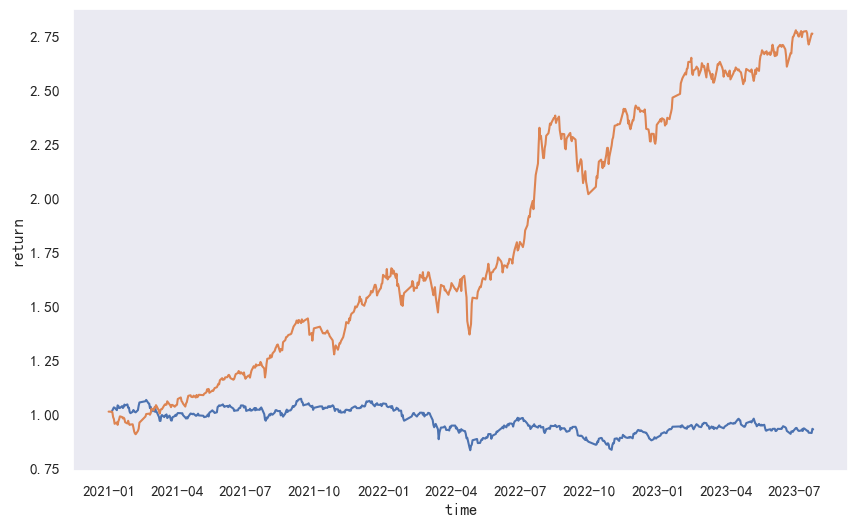

Sharpe:  2.017055853574941
Drawdown: -0.18328285381694312
年化： 0.5310143037051478
beta:  -0.383226795859645  Alpha:  0.5532179890495151


In [14]:
ret_SRHA=output_ret([S,R,H,A])
plot1(ret_SRHA,'SRHA')
print('Sharpe: ',sharpe_ratio_yearly(ret_SRHA))
print('Drawdown:',calculate_drawdown(ret_SRHA.values))
# alpha = calculate_alpha_with_factors(ret_SRHA.values, factors_data[-620:][:,3:4])
# print("Alpha:", alpha)
from sklearn.linear_model import LinearRegression

print('年化：',ret_SRHA[-1]**(260/len(ret_SRHA))-1)

# reg = LinearRegression().fit(factors_data[-620:][:,3:4].transpose().reshape(-1, 1),ret_SRHA.values)
# print('Beta: ',reg.coef_,'; Alpha: ',reg.intercept_ )
x,y = benchmark[-len(ret_SRHA):],ret_SRHA.values.tolist()
Beta = sum((a - np.mean(x)) * (b - np.mean(y)) for (a,b) in zip(x,y)) / len(x)/np.std(x)
Alpha = ret_SRHA[-1]**(260/len(ret_SRHA))-1 - Beta * (benchmark[-len(ret_SRHA):][0]**(260/len(ret_SRHA))-1)
print('beta: ',Beta," Alpha: ",Alpha)